In [1]:
from preprocess import get_img_paths, prep_data
import numpy as np

### Get image file paths

In [2]:
fractured, nfractured = get_img_paths('train')

### Preprocess data for train

In [3]:
x_1, y_1 = prep_data(fractured, 1)
x_0, y_0 = prep_data(nfractured, 0)
x_train = np.concatenate([x_0,x_1], axis=0)
x_train = np.expand_dims(x_train, axis=-1)
y_train = np.concatenate([y_0,y_1], axis=0)
x_train.shape, y_train.shape

((8538, 224, 224, 1), (8538, 1))

### Preprocess data for validation

In [4]:
val_fractured, val_nfractured = get_img_paths('val')
x_1, y_1 = prep_data(val_fractured, 1)
x_0, y_0 = prep_data(val_nfractured, 0)
x_val = np.concatenate([x_0,x_1], axis=0)
x_val = np.expand_dims(x_val, axis=-1)
y_val = np.concatenate([y_0,y_1], axis=0)
x_val.shape, y_val.shape

((582, 224, 224, 1), (582, 1))

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense, LeakyReLU, Reshape, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential, Model
import tensorflow as tf
from tensorflow.keras import layers, models

### Autoencoder architecture (Non-linear dimension reduction)

In [6]:
input_shape = (224, 224, 1)

# Encoder
encoder = Sequential([
    Flatten(input_shape=input_shape),
    
    Dense(255),
    LeakyReLU(alpha=0.1),
    
    Dense(9),
    LeakyReLU(alpha=0.1),
], name="encoder")

# Decoder
decoder = Sequential([
    Dense(255, input_shape=(9,)),
    LeakyReLU(alpha=0.1),
    
    Dense(224 * 224),
    LeakyReLU(alpha=0.1),
    
    Reshape((224, 224, 1))
], name="decoder")

# Combine encoder and decoder to create the autoencoder
autoencoder_input = Input(shape=input_shape)
encoded = encoder(autoencoder_input)
decoded = decoder(encoded)
autoencoder = Model(autoencoder_input, decoded)

autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 encoder (Sequential)        (None, 9)                 12797439  
                                                                 
 decoder (Sequential)        (None, 224, 224, 1)       12847606  
                                                                 
Total params: 25645045 (97.83 MB)
Trainable params: 25645045 (97.83 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [22]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

### Encoder architecture

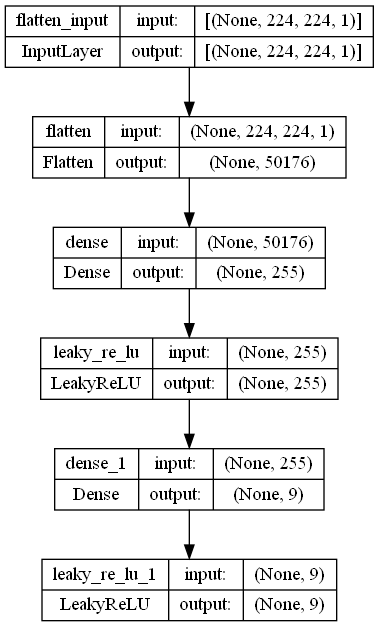

In [24]:
plot_model(encoder, to_file='architecture/encoder_architecture.png', show_shapes=True, show_layer_names=True)
Image(filename='architecture/encoder_architecture.png')

### Decoder Architecture

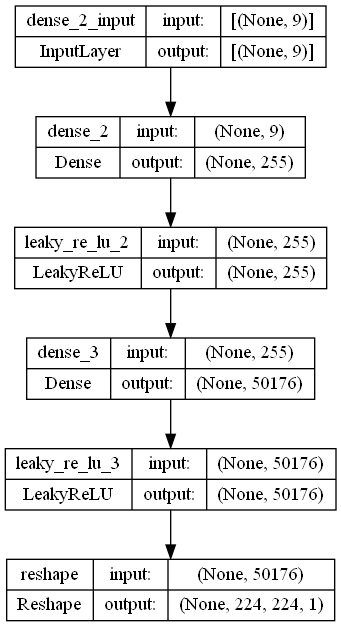

In [25]:
plot_model(decoder, to_file='architecture/decoder_architecture.png', show_shapes=True, show_layer_names=True)
Image(filename='architecture/decoder_architecture.png')

### MSE Loss on Auto encoder-decoder

In [7]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
autoencoder.fit(x_train, x_train, epochs=100, batch_size=64, validation_data=(x_val, x_val), callbacks=[early_stopping])

Epoch 1/100
134/134 [==============================] - 40s 287ms/step - loss: 2302.1313 - val_loss: 1127.3879
Epoch 2/100
134/134 [==============================] - 38s 284ms/step - loss: 999.2071 - val_loss: 891.7142
Epoch 3/100
134/134 [==============================] - 37s 279ms/step - loss: 858.9650 - val_loss: 794.0109
Epoch 4/100
134/134 [==============================] - 36s 272ms/step - loss: 778.6992 - val_loss: 724.6407
Epoch 5/100
134/134 [==============================] - 38s 282ms/step - loss: 732.6827 - val_loss: 688.2428
Epoch 6/100
134/134 [==============================] - 37s 274ms/step - loss: 696.0881 - val_loss: 671.6674
Epoch 7/100
134/134 [==============================] - 38s 281ms/step - loss: 671.2942 - val_loss: 641.1441
Epoch 8/100
134/134 [==============================] - 39s 290ms/step - loss: 646.4746 - val_loss: 615.1891
Epoch 9/100
134/134 [==============================] - 38s 287ms/step - loss: 627.1104 - val_loss: 607.0262
Epoch 10/100
134/134 [====

In [8]:
import matplotlib.pyplot as plt

1/1 [==============================] - 0s 195ms/step


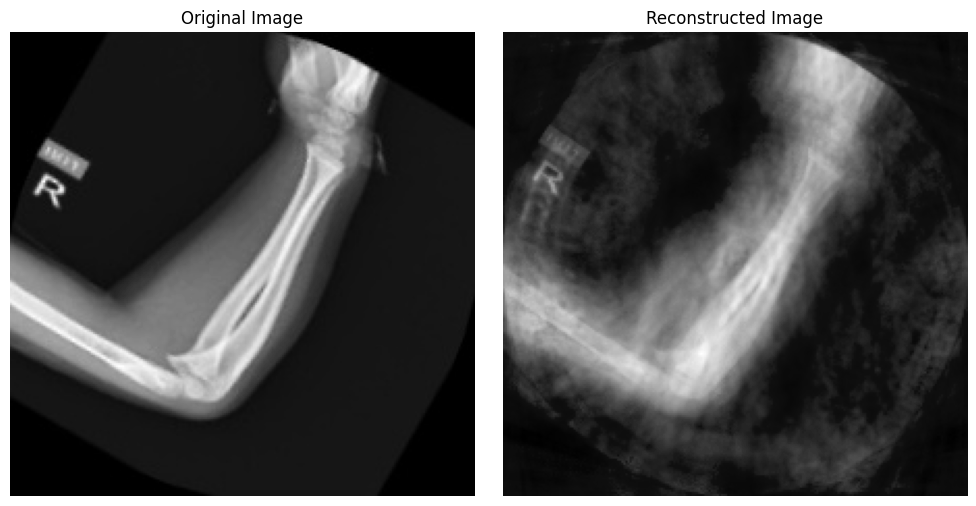

In [9]:
original_image = x_val[123].reshape(224, 224)
reconstructed_image = autoencoder.predict(np.expand_dims(x_val[123],axis=0)).reshape(224, 224)

# Plot the images using matplotlib
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(original_image, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(reconstructed_image, cmap='gray')
axes[1].set_title('Reconstructed Image')
axes[1].axis('off')

plt.tight_layout()
plt.show()

### Pipe PCA (linear dimension reduction) with decoder

In [10]:
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

In [11]:
x_train_flatten = x_train.reshape((x_train.shape[0], -1))
x_val_flatten = x_val.reshape((x_val.shape[0], -1))

pca = PCA(n_components=9)
x_train_pca = pca.fit_transform(x_train_flatten)
x_val_pca = pca.transform(x_val_flatten)

print("x_train_pca shape:", x_train_pca.shape)
print("x_val_pca shape:", x_val_pca.shape)

x_train_pca shape: (8538, 9)
x_val_pca shape: (582, 9)


### MSE Loss on PCA Inverse Transform

In [12]:
x_train_reconstructed = pca.inverse_transform(x_train_pca)
x_val_reconstructed = pca.inverse_transform(x_val_pca)

mse_train = mean_squared_error(x_train.reshape(x_train.shape[0],-1), x_train_reconstructed)
mse_val = mean_squared_error(x_val.reshape(x_val.shape[0], -1), x_val_reconstructed)

print(f"MSE Loss on Training Data: {mse_train}")
print(f"MSE Loss on Validation Data: {mse_val}")

MSE Loss on Training Data: 852.5504516490487
MSE Loss on Validation Data: 830.259665022482


In [13]:
# Define the decoder
pca_decoder = Sequential([
    Dense(120, input_shape=(9,)),
    LeakyReLU(alpha=0.1),
    
    Dense(224 * 224),
    LeakyReLU(alpha=0.1),
    
    Reshape((224, 224, 1))
], name="pca_decoder")

pca_decoder.compile(optimizer='adam', loss='mse')
pca_decoder.summary()

Model: "pca_decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 120)               1200      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 120)               0         
                                                                 
 dense_5 (Dense)             (None, 50176)             6071296   
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 50176)             0         
                                                                 
 reshape_1 (Reshape)         (None, 224, 224, 1)       0         
                                                                 
Total params: 6072496 (23.16 MB)
Trainable params: 6072496 (23.16 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


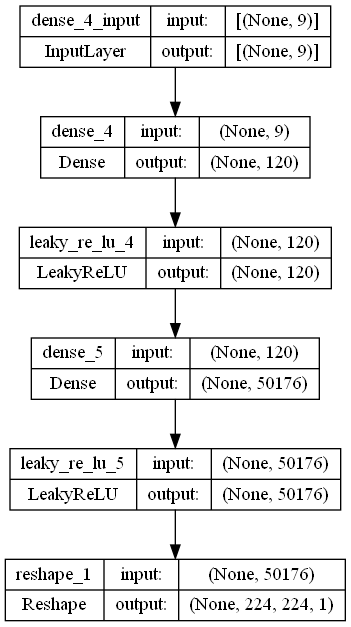

In [27]:
plot_model(pca_decoder, to_file='architecture/pca_decoder_architecture.png', show_shapes=True, show_layer_names=True)
Image(filename='architecture/pca_decoder_architecture.png')

### MSE Loss on PCA + Decoder

In [14]:
pca_decoder.fit(x_train_pca, x_train, epochs=100, batch_size=64, validation_data=(x_val_pca, x_val), callbacks=[early_stopping])

Epoch 1/100
134/134 [==============================] - 16s 115ms/step - loss: 1150.4714 - val_loss: 885.3324
Epoch 2/100
134/134 [==============================] - 14s 108ms/step - loss: 848.0049 - val_loss: 811.7162
Epoch 3/100
134/134 [==============================] - 13s 97ms/step - loss: 803.8388 - val_loss: 780.1849
Epoch 4/100
134/134 [==============================] - 14s 101ms/step - loss: 767.3782 - val_loss: 753.1334
Epoch 5/100
134/134 [==============================] - 13s 99ms/step - loss: 743.4130 - val_loss: 732.6846
Epoch 6/100
134/134 [==============================] - 13s 97ms/step - loss: 724.6758 - val_loss: 724.1791
Epoch 7/100
134/134 [==============================] - 13s 95ms/step - loss: 711.5239 - val_loss: 699.9039
Epoch 8/100
134/134 [==============================] - 12s 92ms/step - loss: 699.6376 - val_loss: 706.8041
Epoch 9/100
134/134 [==============================] - 13s 95ms/step - loss: 690.1371 - val_loss: 680.8113
Epoch 10/100
134/134 [===========

### Classify images with encoder neural network

In [15]:
classifier_layer = Sequential([
    Dense(1, activation='sigmoid', input_shape=(9,))
], name="nn_classifier")

encoded_input = Input(shape=input_shape)
encoded_output = encoder(encoded_input)
classification_output = classifier_layer(encoded_output)
nn_classifier = Model(encoded_input, classification_output)

nn_classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

nn_classifier.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_val, y_val), callbacks=[early_stopping])

Epoch 1/100
267/267 [==============================] - 35s 126ms/step - loss: 60.0380 - accuracy: 0.7453 - val_loss: 7.7165 - val_accuracy: 0.8677
Epoch 2/100
267/267 [==============================] - 34s 129ms/step - loss: 8.4831 - accuracy: 0.8482 - val_loss: 6.0325 - val_accuracy: 0.9089
Epoch 3/100
267/267 [==============================] - 34s 127ms/step - loss: 11.0878 - accuracy: 0.8860 - val_loss: 64.9715 - val_accuracy: 0.4759
Epoch 4/100
267/267 [==============================] - 34s 126ms/step - loss: 9.9126 - accuracy: 0.8706 - val_loss: 1.9328 - val_accuracy: 0.9570
Epoch 5/100
267/267 [==============================] - 34s 127ms/step - loss: 3.7393 - accuracy: 0.9269 - val_loss: 1.2543 - val_accuracy: 0.9708
Epoch 6/100
267/267 [==============================] - 34s 127ms/step - loss: 3.5551 - accuracy: 0.9293 - val_loss: 1.9228 - val_accuracy: 0.9639
Epoch 7/100
267/267 [==============================] - 34s 127ms/step - loss: 1.5693 - accuracy: 0.9630 - val_loss: 1.145

### PCA variance at first 9 components

In [16]:
sum(pca.explained_variance_ratio_)

0.6026426910237251

In [17]:
pca_classifier = Sequential([
    Input(shape=(9,)),
    Dense(1, activation='sigmoid')
], name="pca_classifier")

pca_classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
pca_classifier.fit(x_train_pca, y_train, epochs=100, batch_size=64, validation_data=(x_val_pca, y_val), callbacks=[early_stopping])

Epoch 1/100
134/134 [==============================] - 1s 4ms/step - loss: 1353.3623 - accuracy: 0.5529 - val_loss: 1097.8984 - val_accuracy: 0.5619
Epoch 2/100
134/134 [==============================] - 0s 2ms/step - loss: 1054.2443 - accuracy: 0.5533 - val_loss: 834.8516 - val_accuracy: 0.5584
Epoch 3/100
134/134 [==============================] - 0s 2ms/step - loss: 774.1670 - accuracy: 0.5529 - val_loss: 590.6429 - val_accuracy: 0.5653
Epoch 4/100
134/134 [==============================] - 0s 2ms/step - loss: 520.1737 - accuracy: 0.5574 - val_loss: 372.9927 - val_accuracy: 0.5859
Epoch 5/100
134/134 [==============================] - 0s 2ms/step - loss: 298.3570 - accuracy: 0.5671 - val_loss: 180.8237 - val_accuracy: 0.5911
Epoch 6/100
134/134 [==============================] - 0s 2ms/step - loss: 103.0894 - accuracy: 0.5632 - val_loss: 11.2036 - val_accuracy: 0.5979
Epoch 7/100
134/134 [==============================] - 0s 2ms/step - loss: 1.8180 - accuracy: 0.5590 - val_loss: 1.2

In [18]:
test_fractured, test_nfractured = get_img_paths('test')
x_1, y_1 = prep_data(test_fractured, 1)
x_0, y_0 = prep_data(test_nfractured, 0)
x_test = np.concatenate([x_0,x_1], axis=0)
x_test = np.expand_dims(x_test, axis=-1)
y_test = np.concatenate([y_0,y_1], axis=0)
x_test.shape, y_test.shape

((392, 224, 224, 1), (392, 1))

In [19]:
from sklearn.metrics import confusion_matrix
import plotly.express as px

def make_cx(y_true, y_pred, model_name = ''):
    cm = confusion_matrix(y_true, y_pred)

    fig = px.imshow(
        cm,
        text_auto=True,
        labels=dict(x="Predicted Label", y="True Label", color="Count"),
        x=['Predicted fractured', 'Predicted nonfractured'],
        y=['Actual fractured', 'Actual nonfractured'],
        title="Confusion Matrix: " + model_name
    )

    return fig.show()

In [20]:
make_cx(y_test, nn_classifier.predict(x_test).astype(np.int32), 'Autoencoder')

13/13 [==============================] - 0s 14ms/step


In [21]:
make_cx(y_test, pca_classifier.predict(pca.transform(x_test.reshape(x_test.shape[0],-1))).astype(np.int32), 'PCA - k = 9')

13/13 [==============================] - 0s 1ms/step
